In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from pyFTS.benchmarks import Measures
import math
from pyFTS.common import Util
import datetime
import statistics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

## Aux functions

In [3]:
# convert series to supervised learning
def series_to_supervised_miso(data, n_in, n_out, endog_var, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [(df.columns[j]+'(t-%d)' % (i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df[endog_var].shift(-i))
		if i == 0:
			names += [(endog_var+'(t)')]
		else:
			names += [(endog_var+'(t+%d)' % (i))]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [4]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame) 
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [5]:
def cal_nrmse(rmse, y):
    x = max(y)-min(y)
    return (rmse/x)

## Dataset Energy Appliances

In [6]:
dataset = pd.read_csv('/home/hugo/projetos-doutorado/Appliance-Energy-Prediction/data/energydata_complete.csv')
data = dataset.drop(labels=['date','rv1','rv2'], axis=1)
data = clean_dataset(data)
values = data.values
#values

## Dataset Energy Appliance: Preprocessing, Lag = 1, t+1

In [7]:
cols = data.columns
list_cols = list(cols)

In [8]:
# normalize features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
data_scaled = pd.DataFrame(scaled, columns=list_cols)
# frame as supervised learning
data_scaled = series_to_supervised_miso(data_scaled, 1, 1,endog_var='Appliances')
data_scaled.head()

,Appliances(t-1),lights(t-1),T1(t-1),RH_1(t-1),T2(t-1),RH_2(t-1),T3(t-1),RH_3(t-1),T4(t-1),RH_4(t-1),...,RH_8(t-1),T9(t-1),RH_9(t-1),T_out(t-1),Press_mm_hg(t-1),RH_out(t-1),Windspeed(t-1),Visibility(t-1),Tdewpoint(t-1),Appliances(t)
1,0.046729,0.428571,0.32735,0.566187,0.225345,0.684038,0.215188,0.746066,0.351351,0.764262,...,0.661412,0.223032,0.677290,0.372990,0.097674,0.894737,0.500000,0.953846,0.538462,0.046729
2,0.046729,0.428571,0.32735,0.541326,0.225345,0.682140,0.215188,0.748871,0.351351,0.782437,...,0.660155,0.226500,0.678532,0.369239,0.100000,0.894737,0.476190,0.894872,0.533937,0.037383
3,0.037383,0.428571,0.32735,0.530502,0.225345,0.679445,0.215188,0.755569,0.344745,0.778062,...,0.655586,0.219563,0.676049,0.365488,0.102326,0.894737,0.452381,0.835897,0.529412,0.037383
4,0.037383,0.571429,0.32735,0.524080,0.225345,0.678414,0.215188,0.758685,0.341441,0.770949,...,0.650788,0.219563,0.671909,0.361736,0.104651,0.894737,0.428571,0.776923,0.524887,0.046729
5,0.046729,0.571429,0.32735,0.531419,0.225345,0.676727,0.215188,0.758685,0.341441,0.762697,...,0.650788,0.219563,0.671909,0.357985,0.106977,0.894737,0.404762,0.717949,0.520362,0.037383


In [9]:
data = series_to_supervised_miso(data, 1, 1,endog_var='Appliances')
data.head()

,Appliances(t-1),lights(t-1),T1(t-1),RH_1(t-1),T2(t-1),RH_2(t-1),T3(t-1),RH_3(t-1),T4(t-1),RH_4(t-1),...,RH_8(t-1),T9(t-1),RH_9(t-1),T_out(t-1),Press_mm_hg(t-1),RH_out(t-1),Windspeed(t-1),Visibility(t-1),Tdewpoint(t-1),Appliances(t)
1,60.0,30.0,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,60.0
2,60.0,30.0,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,50.0
3,50.0,30.0,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,50.0
4,50.0,40.0,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,60.0
5,60.0,40.0,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,50.0


## Model: SARIMAX

### Define SARIMAX parameters

In [10]:
values = data.values
values.shape

(19734, 27)

In [11]:
values = data.values
train_size=int(len(values)*0.30)
test_size = int(len(values)) - train_size
print(test_size)

13814


In [13]:
# split into train and test sets
# train_X, train_y = data_scaled.loc[:,'Appliances(t-1)':'Tdewpoint(t-1)'].values[:train_size], data_scaled['Appliances(t-1)'].values[:train_size]
# test_X, test_y = data_scaled.loc[:,'Appliances(t-1)':'Tdewpoint(t-1)'].values[train_size:], data_scaled['Appliances(t)'].values[train_size:]

# train_y.reshape(-1)
# test_y.reshape(-1)


train_X, train_y = data_scaled.loc[:,'Appliances(t-1)':'Tdewpoint(t-1)'].values[:train_size], data_scaled['Appliances(t)'].values[:train_size]
test_X, test_y = data_scaled.loc[:,'Appliances(t-1)':'Tdewpoint(t-1)'].values[train_size:], data_scaled['Appliances(t)'].values[train_size:]

train_y.reshape(-1)
test_y.reshape(-1)

# # split into input (all columns exceptc last one) and outputs (last column)
# train_X, train_y = train_X[:, :-1], train_y[:, -1]
# test_X, test_y = test_X[:, :-1], test_y[:, -1]

# # reshape input to be 3D [samples, timesteps, features]; each line turns into an 'sub-array'
# train_X = train_X.reshape((train_X.shape[0],train_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0],test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5920, 26) (5920,) (13814, 26) (13814,)


In [12]:
# cols = data.columns
# list_cols_exog = list(cols)
# list_cols_exog.remove("Appliances(t)")

In [13]:
# df_train_X = pd.DataFrame(train_X,columns=list_cols_exog)
# df_test_X = pd.DataFrame(train_X,columns=list_cols_exog)

In [14]:
# list_cols_endog = []
# list_cols_endog.append('Appliances(t)')
# df_train_y = pd.DataFrame(train_y,columns=list_cols_endog)
# df_test_y = pd.DataFrame(test_y,columns=list_cols_endog)
# #df_train_y

In [15]:
# train_y.shape

In [16]:
# from matplotlib import pyplot
# from statsmodels.graphics.tsaplots import plot_acf
# plot_acf(train_y)
# pyplot.show()

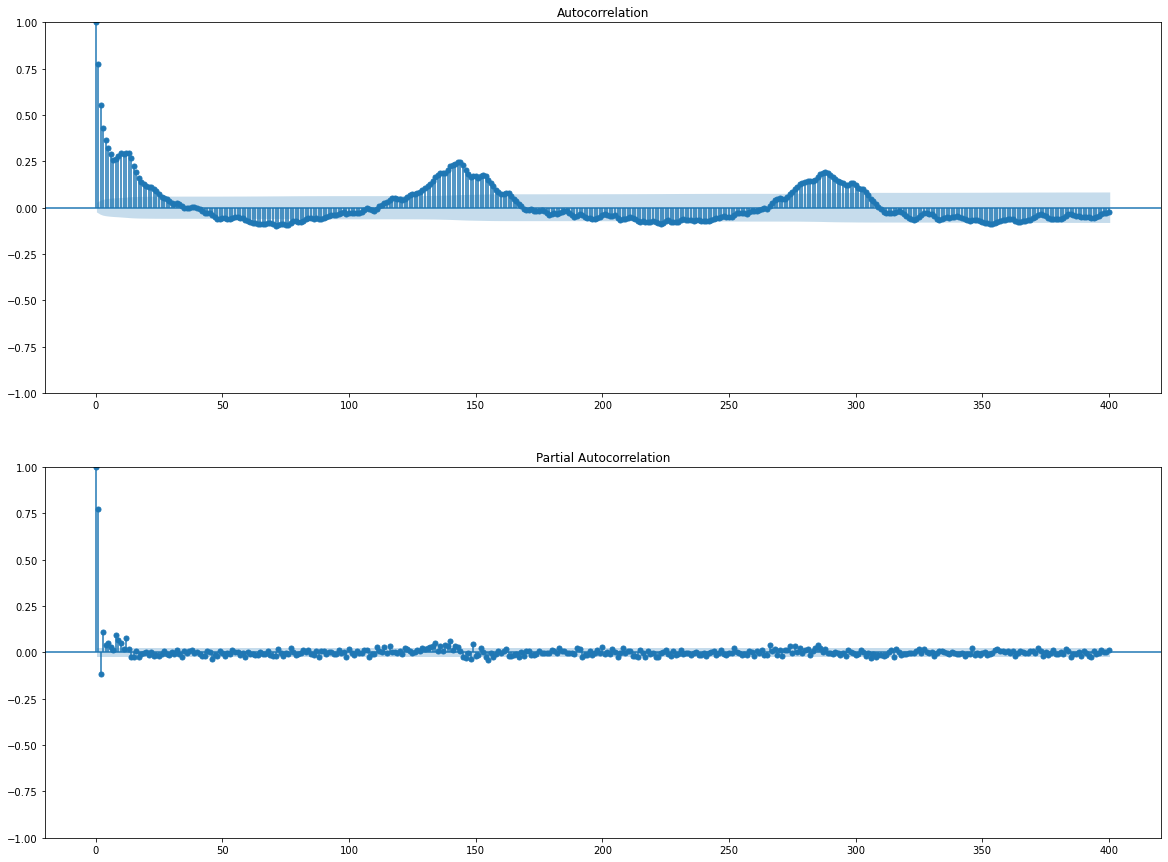

In [17]:
#Correlograms
fig,ax= plt.subplots(2,1, figsize=(20,15))
fig=sm.tsa.graphics.plot_acf(train_y, lags=400, ax=ax[0])
fig=sm.tsa.graphics.plot_pacf(train_y, lags=400, ax=ax[1])
plt.show()

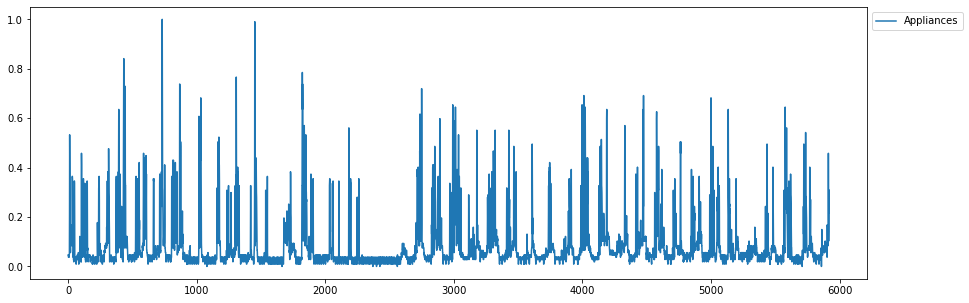

In [18]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 5])
ax.plot(train_y, label='Appliances')
handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
plt.show()

In [436]:
# from statsmodels.tsa.seasonal import seasonal_decompose
# import matplotlib.pyplot as plt
# result = seasonal_decompose(train_y,model='add',period=140)
# fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(30,15))
# result.trend.plot(ax=ax1)
# result.resid.plot(ax=ax2)
# result.seasonal.plot(ax=ax3)

In [437]:
# from pmdarima.arima import auto_arima
# step_wise=auto_arima(train_y, 
#  exogenous= train_X,
#  start_p=1, start_q=1, 
#  max_p=3, max_q=3, 
#  d=1, max_d=3,
#  trace=True, 
#  error_action='ignore', 
#  suppress_warnings=True, 
#  stepwise=True,
#  seasonal=True)

In [438]:
# m = 7 => daily
# m = 54 => weekly
# sarimax_model = auto_arima(train_y,
#                        exogenous= train_X,
#                        test='adf'
#                        start_p=1,
#                        start_q=1,
#                        max_p=3,
#                        max_q=3,
#                        m=7,
#                        seasonal=True,
#                        d=None,
#                        D=1,
#                        trace=True,
#                        error_action='ignore',
#                        suppress_warnings=True,
#                        stepwise=True)

In [40]:
# # m = 7 => daily
# # m = 52 => weekly
# sarimax_model = auto_arima(train_y,
#                        exogenous= train_X,
#                        test='adf',
#                        start_p=0,
#                        start_q=0,
#                        max_p=5,
#                        max_q=5,
#                        start_Q=0,
#                        start_P=0,
#                        max_P=5,
#                        max_Q=5,
#                        m=7,
#                        seasonal=True,
#                        d=None,
#                        D=1,
#                        max_D=5,
#                        trace=True,
#                        error_action='ignore',
#                        suppress_warnings=True,
#                        stepwise=True)
# #                        n_fits = 50)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=-130023.969, Time=42.63 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=-130008.401, Time=125.03 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=-125925.368, Time=179.30 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=-125082.174, Time=28.79 sec
 ARIMA(0,0,0)(1,1,0)[7] intercept   : AIC=-130010.401, Time=99.62 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=-125927.368, Time=188.52 sec
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=-125601.953, Time=108.28 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=-130021.969, Time=45.56 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=-130021.969, Time=58.10 sec
 ARIMA(1,0,1)(0,1,0)[7] intercept   : AIC=-130019.969, Time=62.55 sec

Best model:  ARIMA(0,0,0)(0,1,0)[7] intercept
Total fit time: 938.473 seconds


In [328]:
# Best model:  ARIMA(0,0,1)(0,1,2)[12] intercept
#ARIMA(0,0,1)(1,1,2)[7] 
# Total fit time: 11753.701 seconds

# Best model:  ARIMA(0,0,1)(1,1,2)[7] intercept
# Total fit time: 5686.746 seconds

# Best model:  ARIMA(0,0,1)(0,1,1)[4] intercept
# Total fit time: 1330.512 seconds

# Best model:  ARIMA(0,0,1)(0,1,1)[7]          
# Total fit time: 5811.561 seconds

# Best model:  ARIMA(0,0,1)(1,1,2)[7] intercept
# Total fit time: 5686.746 seconds

#sarimax_model.summary()

In [413]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# model= SARIMAX(endog=train_y, 
#  exog=train_X,
#  order=(3,1,2),
#  seasonal_order=(0,1,2,7),
#  enforce_invertibility=False, 
#  enforce_stationarity=False)

In [331]:
# results = model.fit(disp=True)

In [332]:
# results.summary()

In [333]:
# steps = -1
# yhat = results.predict(start=train_size, end=train_size+test_size+(steps),exog=test_X)
# #yhat

In [334]:
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
# # invert scaling for forecast
# inv_yhat = np.concatenate((yhat.reshape(len(yhat),1), test_X[:, 1:]), axis=1)
# print(inv_yhat.shape)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]
# # invert scaling for actual - observed data
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]

In [335]:
# rmse = Measures.rmse(inv_yhat,inv_y)
# mape = Measures.mape(inv_yhat,inv_y)
# smape = Measures.smape(inv_yhat,inv_y)
# print('Test RMSE: %.3f' % rmse)
# print('Test MAPE: %.3f' % mape)
# print('Test SMAPE: %.3f' % smape)

In [336]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
# ax.plot(inv_y[1:300], label='Original')
# ax.plot(inv_yhat[1:300], label='Forecast')
# handles, labels = ax.get_legend_handles_labels()
# lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
# plt.show()

## Model: SARIMAX - Final model

In [337]:
#Hyperparameters tested 
#order=(1,0,1), seasonal_order=(1,1,2,7) ==> 190.596548	152.632719	209.728747	56.147391
#order=(0,0,1),seasonal_order=(1,1,2,7), ==> 174.413487	139.909065	194.543149	54.981554
#order=(0,0,1), seasonal_order=(0,1,2,7),==> 174.524915	140.547848	196.664085	55.025367
#**order=(0,0,1), seasonal_order=(0,1,1,7),==> 172.282777	139.149823	195.941663	53.800212
#order=(3,1,2), seasonal_order=(1,1,2,7),==> 2.145111e+06	719710.123596	672833.125393	78.183915
#order=(0,0,1), seasonal_order=(0,0,1,7),==> 166.464915	132.687967	184.941603	53.354538

# Best model:  ARIMA(1,0,0)(0,1,0)[7] ==> 257.050865	213.171839	309.926134	64.061179          
# Total fit time: 890.419 seconds
# ARIMA(1,0,0)(1,1,0)[7]==> 221.639305	180.737487	259.582936	57.971092
# ARIMA(1,0,0)(0,1,1)[7]            
# ARIMA(1,0,0)(1,1,0)[7]             
# ARIMA(1,0,0)(0,1,1)[7]             

In [14]:
def train_sarimax(endog, exog, order, seasonal_order):
    model=sm.tsa.SARIMAX(endog = endog, exog = exog, 
                          order=order,
                          seasonal_order=seasonal_order, 
                          enforce_invertibility=False, 
                          enforce_stationarity=False)
    sarimax = model.fit()
    return sarimax


def test_sarimax(model,start,end,exog):
    forecasts = model.predict(start=start, end=end, exog=exog)
    return forecasts
    

In [15]:
def transform_original(test_X,test_y,yhat):
    test_X = test_X.reshape((test_X.shape[0], test_X.shape[1]))
    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat.reshape(len(yhat),1), test_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual - observed data
    test_y = test_y.reshape((len(test_y), 1))
    inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    
#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[15, 3])
#     ax.plot(inv_y, label='Original')
#     ax.plot(inv_yhat, label='Forecast')
#     handles, labels = ax.get_legend_handles_labels()
#     lgd = ax.legend(handles, labels, loc=2, bbox_to_anchor=(1, 1))
#     plt.show()
    
    return inv_y,inv_yhat

## Sliding Window PyFTS: SARIMAX

In [16]:
result = {
     "window": [],
     "rmse": [],
     "mae": [],
     "mape": [],
     "smape": [],
     "nrmse":[]
}

tam = len(data)
n_windows = 30
windows_length = math.floor(tam / n_windows)
for ct, ttrain, ttest in Util.sliding_window(data_scaled, windows_length, 0.75, inc=1):
    if len(ttest) > 0:
        
        start = len(ttrain)
        end = len(ttrain)+ len(ttest) -1
        
        print('-' * 20)
        print(f'training window {(ct)}')
        model = train_sarimax(endog = ttrain.loc[:,'Appliances(t)'], 
                              exog = ttrain.loc[:,'lights(t-1)':'Tdewpoint(t-1)'], 
                              order = [0,0,1], 
                              seasonal_order = [0,1,1,7])
        
        yhat = test_sarimax(model, start, end, exog=ttest.loc[:,'lights(t-1)':'Tdewpoint(t-1)']) 
        
        print("[{0: %H:%M:%S}]".format(datetime.datetime.now()) + f" getting statistics")

        test_X = ttest.loc[:,'Appliances(t-1)':'Tdewpoint(t-1)'].values
        test_X = test_X.reshape((test_X.shape[0],test_X.shape[1]))
        test_y = ttest['Appliances(t)'].values
        
        appliances,forecast = transform_original(test_X = test_X,test_y = test_y,yhat = yhat.values)
        
        rmse = Measures.rmse(appliances,forecast)
        mape = Measures.mape(appliances,forecast)
        smape = Measures.smape(appliances,forecast)
        
        forecast = pd.DataFrame(forecast)
        forecast.fillna(forecast.mean(),inplace=True)
        forecast = np.array(forecast).reshape(-1)
        mae = mean_absolute_error(appliances, forecast)
        
        nrmse = cal_nrmse(rmse, appliances)
                
        result["rmse"].append(round(rmse,3))
        result["mae"].append(round(mae,3))
        result["mape"].append(round(mape,3))
        result["smape"].append(round(smape,3))
        result["nrmse"].append(round(nrmse,3))
        result["window"].append(ct)

measures = pd.DataFrame(result)


--------------------
training window 0


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/hugo/anaconda3

[ 23:27:05] getting statistics
--------------------
training window 657


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


[ 23:27:20] getting statistics
--------------------
training window 1314


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


[ 23:27:35] getting statistics
--------------------
training window 1971


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


[ 23:27:52] getting statistics
--------------------
training window 2628


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


[ 23:28:08] getting statistics
--------------------
training window 3285


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


[ 23:28:24] getting statistics
--------------------
training window 3942


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


[ 23:28:42] getting statistics
--------------------
training window 4599


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


[ 23:28:57] getting statistics
--------------------
training window 5256


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


[ 23:29:12] getting statistics
--------------------
training window 5913


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


[ 23:29:28] getting statistics
--------------------
training window 6570


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


[ 23:29:43] getting statistics
--------------------
training window 7227


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


[ 23:29:59] getting statistics
--------------------
training window 7884


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


[ 23:30:16] getting statistics
--------------------
training window 8541


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


[ 23:30:30] getting statistics
--------------------
training window 9198


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


[ 23:30:45] getting statistics
--------------------
training window 9855


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


[ 23:31:01] getting statistics
--------------------
training window 10512


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


[ 23:31:13] getting statistics
--------------------
training window 11169


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


[ 23:31:27] getting statistics
--------------------
training window 11826


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


[ 23:31:41] getting statistics
--------------------
training window 12483


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


[ 23:31:56] getting statistics
--------------------
training window 13140


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


[ 23:32:09] getting statistics
--------------------
training window 13797


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


[ 23:32:22] getting statistics
--------------------
training window 14454


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


[ 23:32:35] getting statistics
--------------------
training window 15111


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


[ 23:32:48] getting statistics
--------------------
training window 15768


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


[ 23:33:02] getting statistics
--------------------
training window 16425


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


[ 23:33:17] getting statistics
--------------------
training window 17082


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


[ 23:33:31] getting statistics
--------------------
training window 17739


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


[ 23:33:44] getting statistics
--------------------
training window 18396


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


[ 23:33:58] getting statistics
--------------------
training window 19053


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[ 23:34:10] getting statistics


/home/hugo/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [17]:
measures

,window,rmse,mae,mape,smape,nrmse
0,0,209.323,171.710,263.335,49.828,0.436
1,657,415.183,352.147,521.305,62.236,0.513
2,1314,406.794,267.534,226.914,68.484,0.490
3,1971,61.757,48.906,127.495,55.378,0.618
4,2628,192.104,175.634,254.805,49.921,0.337
5,3285,101.831,87.920,165.851,40.796,0.248
6,3942,163.073,127.312,135.953,62.569,0.223
7,4599,140.001,101.341,120.771,70.822,0.209
8,5256,158.328,129.519,187.939,46.965,0.323
9,5913,131.002,77.138,77.272,42.793,0.172


In [29]:
#measures.to_csv (r'win_sarimax_aec.csv', index = False, header=True)

### Mean Statistics SARIMAX

In [19]:
final_result = {
     "rmse": [],
     "mae": [],
     "mape": [],
     "smape": [],
     "nrmse":[],
     "rmse_std": [],
     "mae_std": [],
     "mape_std": [],
     "smape_std": [],
     "nrmse_std": []
}

final_result["rmse"].append(round(statistics.mean(measures['rmse']),3))
final_result["mape"].append(round(statistics.mean(measures['mape']),3))
final_result["smape"].append(round(statistics.mean(measures['smape']),3))
final_result["mae"].append(round(statistics.mean(measures['mae']),3))
final_result["nrmse"].append(round(statistics.mean(measures['nrmse']),3))

final_result["rmse_std"].append(round(statistics.stdev(measures['rmse']),3))
final_result["mape_std"].append(round(statistics.stdev(measures['mape']),3))
final_result["smape_std"].append(round(statistics.stdev(measures['smape']),3))
final_result["mae_std"].append(round(statistics.stdev(measures['mae']),3))
final_result["nrmse_std"].append(round(statistics.stdev(measures['nrmse']),3))
        
final_measures_pca = pd.DataFrame(final_result)

print("Mean Statistics SARIMAX (test): ")
final_measures_pca

Mean Statistics SARIMAX (test): 


,rmse,mae,mape,smape,nrmse,rmse_std,mae_std,mape_std,smape_std,nrmse_std
0,172.069,136.197,183.285,53.515,0.392,85.944,69.318,97.133,15.268,0.304


In [ ]:
#final_measures_pca.to_csv (r'sarimax_aec.csv', index = False, header=True)